In [1]:
import sys
sys.path.insert(1, '../..')
sys.path.insert(1, '../')

import convml_tt


from utils import *

from convml_tt.system import TripletTrainerModel, TripletTrainerDataModule
from convml_tt.data.examples import fetch_example_dataset, ExampleData, fetch_pretrained_model, PretrainedModel
from convml_tt.data.dataset import TileType, ImageSingletDataset
from convml_tt.utils import get_embeddings
import convml_tt.interpretation
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import xarray as xr
import pandas as pd
import pytorch_lightning as pl
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import torch
from sklearn.decomposition import PCA
from PIL import Image
import os, shutil
from matplotlib.patches import Rectangle as rectan
from random import seed
from random import randint
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid

from convml_tt.interpretation.rectpred.transform import apply_transform
from convml_tt.data.examples import load_pretrained_model, PretrainedModel
from convml_tt.interpretation.rectpred.data import make_sliding_tile_model_predictions
from convml_tt.interpretation.rectpred.plot import make_rgb
from tqdm.notebook import tqdm
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


TILE_FILENAME_FORMAT = "{triplet_id:05d}_{tile_type}.png"
TEST_SIZE = 0.3
RANDOM_STATE = 1024
COLORS = ['b', 'g', 'r', 'm'] # Color of each class
DATASETS_path = "../../../../DATASETS/"
print(cv2.__version__)
print(np.__version__)
pca = PCA(n_components=3, svd_solver='arpack')



4.5.2
4.5.2
1.20.0


filename : ../../../../DATASETS/MULTI_SCALE/612/train/00004_anchor.png


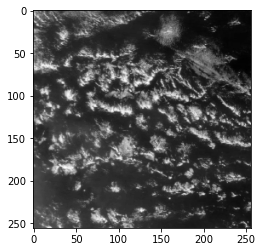

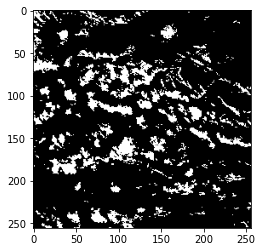

area : [9831]
ecc : [0.48347786]
eqdia : [111.88037345]


In [3]:
from skimage import measure
import tools as tl
from copy import deepcopy


div = 612
idx = 4
tm = TILE_FILENAME_FORMAT.format(triplet_id=idx,tile_type='anchor')
filename = DATASETS_path+"MULTI_SCALE/"+str(div)+"/train/"+tm
print("filename : "+str(filename))
img = cv2.imread(filename, 0)

ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
plt.figure()
plt.imshow(img, cmap='gray')
plt.figure()
plt.imshow(thresh1, cmap='gray')
plt.show()

OBJ = thresh1
OBJ = np.ma.masked_array(OBJ, mask=(OBJ==0))
cloudprop = measure.regionprops(OBJ)
objmask = tl.do_unique(deepcopy(OBJ))

area = np.asarray([prop.area for prop in cloudprop])
ecc  = np.asarray([prop.eccentricity for prop in cloudprop])
eqdia = np.asarray([prop.equivalent_diameter for prop in cloudprop])
nd              = tl.neighbor_distance(cloudprop,mindist=mindist)
indice1   = tl.scai(cloudprop, objmask, connectivity=1)
indice2   = tl.iorg(nd, objmask)
print("area : "+str(area))
print("ecc : "+str(ecc))
print("eqdia : "+str(eqdia))

In [4]:
model = TripletTrainerModel.load_from_checkpoint(checkpoint_path="c:/Users/Ray/Documents/Stage/MODELS/zooniverse-model.ckpt")

  0%|          | 0/14 [00:00<?, ?it/s]DATASET : ../../../../DATASETS/MULTI_SCALE/612/
['labels.pickle', 'train']
100%|██████████| 14/14 [00:25<00:00,  1.82s/it]
424
424
(4, 12)
(4,)
(12, 4)
424


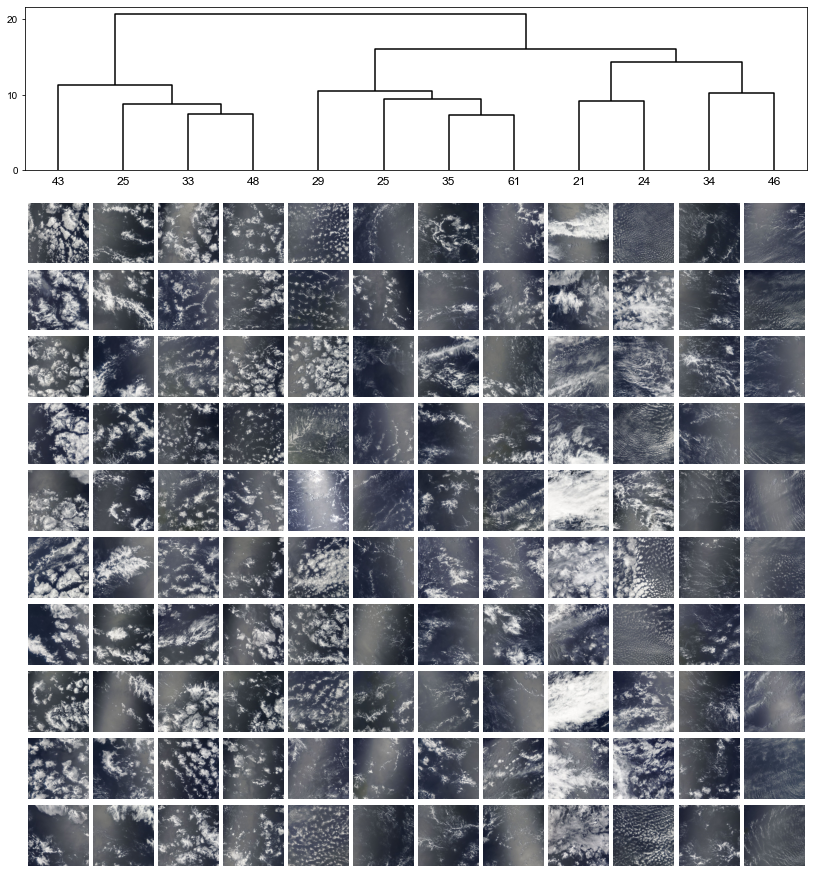

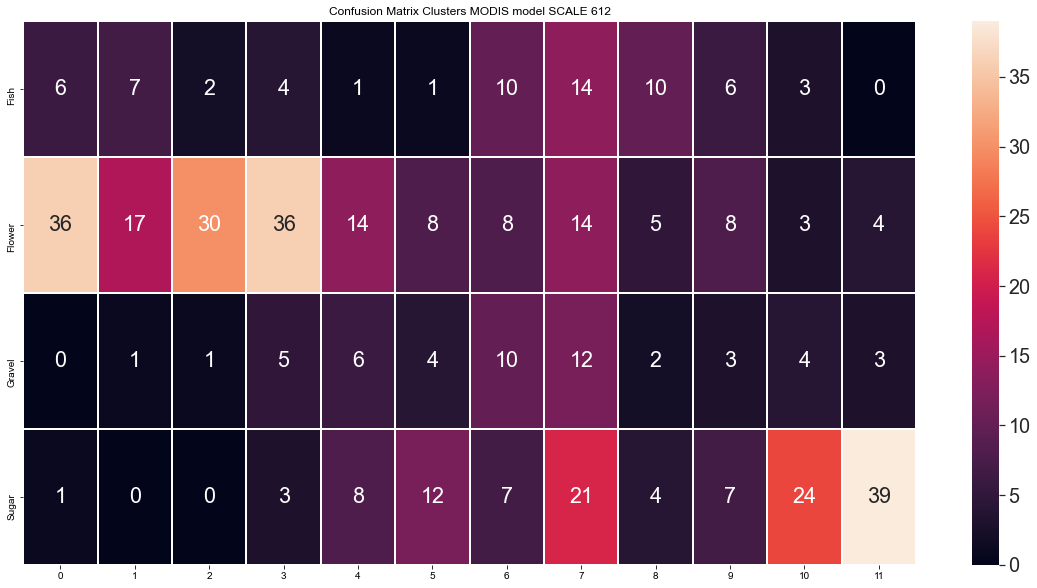

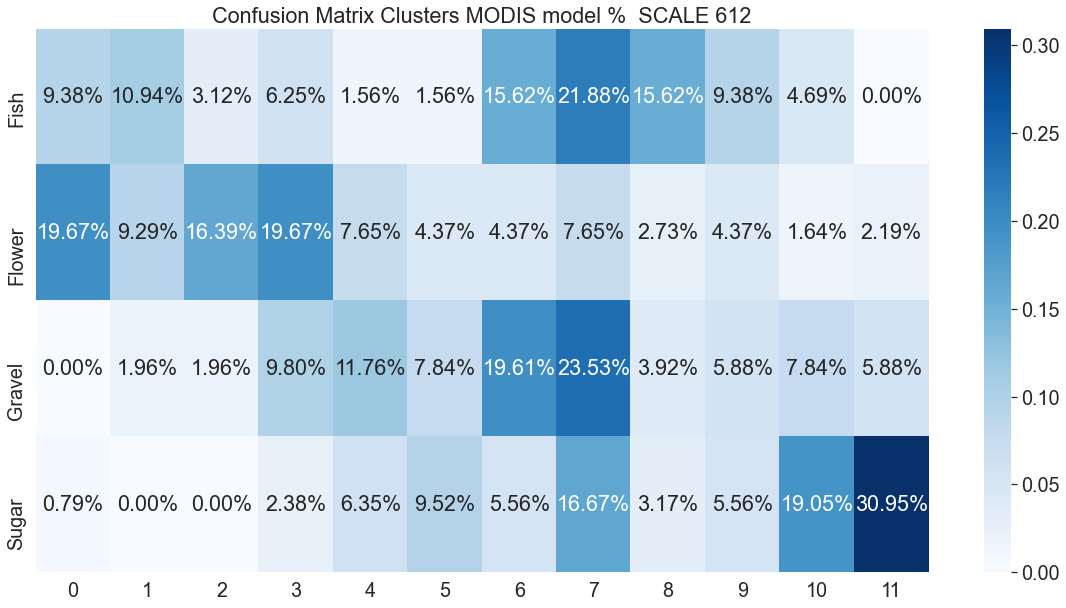

In [5]:
import os
#divisions = [64, 128, 256, 512, 612, 850, 1024]
divisions = [612]
for div in divisions:
    dataset_path =  DATASETS_path+'MULTI_SCALE/'+str(div)+'/'
    print("DATASET : "+str(dataset_path))
    print(os.listdir(dataset_path))
    tile_dataset = ImageSingletDataset(data_dir=dataset_path, tile_type=TileType.ANCHOR)
    da_embeddings = get_embeddings(tile_dataset=tile_dataset, model=model)
    clusters = convml_tt.interpretation.plots.dendrogram(da_embeddings, n_samples=10, n_clusters_max=12, return_clusters=True)#, label_clusters=True)
    with open(DATASETS_path+"MULTI_SCALE/"+str(div)+"/labels.pickle", "rb") as handle:
        labs = pickle.load(handle)
    try:
        labs = labs[:25001]
    except:
        labs = labs
    print(len(labs))
    print(len(clusters[1]))
    clclc = list(map(int, clusters[1]))
    cfs_mat = confusion_matrix(labs, clclc)

    associations = ['Fish', 'Flower', 'Gravel', 'Sugar']
    fig, ax = plt.subplots(figsize=(20,10)) 
    plt.title("Confusion Matrix Clusters MODIS model SCALE "+str(div))
    sns.set(font_scale=1.8)
    sns.heatmap(cfs_mat[:4,:], annot=True, fmt='', ax=ax, linewidths=.9, yticklabels=associations)
    fig, ax = plt.subplots(figsize=(20,10))
    print(cfs_mat[:4,:].shape)
    print(   np.sum(  cfs_mat[:4,:], axis=1  ).shape  )
    print(   (  cfs_mat[:4,:].T/np.sum(cfs_mat[:4,:], axis=1)    ).shape  )
    plt.title("Confusion Matrix Clusters MODIS model %  SCALE "+str(div))
    sns.heatmap( (cfs_mat[:4,:].T/np.sum(cfs_mat[:4,:], axis=1)).T, annot=True, 
                fmt='.2%', cmap='Blues' , yticklabels=associations)
    print(len(da_embeddings))
    

In [25]:
areas = []
eccs = []
eqdias = []
nds = []
indices1 = []
indices2 = []

for idx in tqdm(range(len(labs))):
    
    #idx = 4
    tm = TILE_FILENAME_FORMAT.format(triplet_id=idx,tile_type='anchor')
    filename = DATASETS_path+"MULTI_SCALE/"+str(div)+"/train/"+tm
    #print("filename : "+str(filename))
    img = cv2.imread(filename, 0)

    ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    """
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.figure()
    plt.imshow(thresh1, cmap='gray')
    plt.show()
    """
    OBJ = thresh1
    OBJ = np.ma.masked_array(OBJ, mask=(OBJ==0))
    cloudprop = measure.regionprops(OBJ)
    objmask = tl.do_unique(deepcopy(OBJ))

    area = np.asarray([prop.area for prop in cloudprop])
    ecc  = np.asarray([prop.eccentricity for prop in cloudprop])
    eqdia = np.asarray([prop.equivalent_diameter for prop in cloudprop])

    #nd = tl.neighbor_distance(cloudprop, mindist=30)
    indice1 = tl.scai(cloudprop, objmask, connectivity=1)
    #indice2 = tl.iorg(nd, objmask)

    areas.append(area[0])
    eccs.append(ecc[0])
    eqdias.append(eqdia[0])
    #nds.append(nd[0])
    indices1.append(indice1)
    #indices2.append(indice2[0])

  0%|          | 0/424 [00:00<?, ?it/s]

In [27]:
print(len(areas))
print(len(labs))
print(areas)
print("\n\n")
print(labs)
print("\n\n")
print(indices1)

424
424
[22502, 3389, 14491, 7796, 9831, 7724, 2029, 3393, 15204, 4373, 24651, 17279, 14352, 16024, 13162, 1657, 3440, 7417, 14585, 11268, 19478, 5350, 10965, 6156, 13365, 3029, 11346, 24927, 9361, 5465, 10922, 5162, 7312, 5767, 27912, 36047, 5327, 1099, 10260, 14284, 2085, 802, 1671, 23991, 25135, 19469, 12058, 6177, 5359, 23567, 2166, 6942, 1848, 8660, 19903, 2122, 24120, 1360, 2541, 12067, 7503, 10674, 3229, 2891, 1414, 7914, 15079, 4582, 3526, 18513, 11807, 10469, 20744, 9996, 9354, 25039, 40028, 14186, 1939, 11288, 20552, 27179, 5611, 9138, 7711, 8075, 38586, 12106, 9580, 17495, 31185, 2108, 4621, 5024, 19374, 17380, 3168, 3401, 21238, 13830, 3584, 4665, 6064, 3708, 14591, 14766, 14654, 7901, 16437, 9560, 892, 32260, 7589, 4565, 13731, 12108, 5667, 2172, 9581, 7601, 13723, 980, 8033, 16349, 9180, 4449, 13335, 7732, 18136, 1858, 29823, 14303, 23339, 1851, 7025, 5612, 19430, 8318, 17766, 18051, 3060, 18986, 4336, 14809, 3673, 6962, 6250, 4733, 12058, 5759, 8775, 1205, 10207, 12390, 

In [18]:
from scipy.stats.stats import pearsonr  
print(np.corrcoef(np.array(labs), np.array(areas)))
print(np.corrcoef(np.array(labs), np.array(eccs)))
print(np.corrcoef(np.array(labs), np.array(eqdias)))

[[ 1.        -0.4949963]
 [-0.4949963  1.       ]]
[[1.         0.18276995]
 [0.18276995 1.        ]]
[[ 1.         -0.56647823]
 [-0.56647823  1.        ]]


In [26]:
print(np.corrcoef(np.array(clusters[1]), np.array(areas)))
print(np.corrcoef(np.array(clusters[1]), np.array(eccs)))
print(np.corrcoef(np.array(clusters[1]), np.array(eqdias)))
print(np.corrcoef(np.array(clusters[1]), np.array(indices1)))
#print(np.corrcoef(np.array(clusters[1]), np.array(eccs)))
#print(np.corrcoef(np.array(clusters[1]), np.array(eqdias)))

[[ 1.        -0.3161706]
 [-0.3161706  1.       ]]
[[1.         0.21412299]
 [0.21412299 1.        ]]
[[ 1.         -0.41282937]
 [-0.41282937  1.        ]]
[[ 1. nan]
 [nan nan]]
